# 단순 선형 회귀 (학습성능개선)
텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있음

1. 데이터 표준화: 학습률 향상에 도움을 줌
2. 콜백함수: 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링 하기 위한 도구
## 데이터 정규화(Normalization, 표준화)
### 1) 데이터 정규화의 이해
#### 데이터 정규화란?
모든 데이터가 동일한 정도의 스케일(중요도)로 반영되도록 해 주는 처리

#### 정규화를 해야 하는 이유
머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾는다.

이 때, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 수많은 학습 단계를 거쳐서 최적값에 도달하게 된다.

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

### 2) 데이터 정규화 방법
#### 최소-최대 정규화 (Min-Max Normalization)
모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1 사이의 값으로 변환.

예를 들어 어떤 특성의 최소값이 20이고 최대값이 40인 경우, 30이라는 데이터가 있을 경우, 20은 0, 40은 1로 환산되기 때문에 30은 중간치인 `0.5`로 변환됨.

## 콜백함수
모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링하기 위한 도구

### 콜백함수 사용 방법
#### 콜백 정의
```pyhon
callbacks = [  콜백1, 콜백2, ... 콜백n  ]
```
##### 학습을 위한 fit() 함수에서 callbacks 파라미터에 미리 정의한 리스트를 지정
```python
callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = callbacks)
```
혹은
```python
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = [
    콜백1, 콜백2, ... , 콜백n
])
```

### 콜백함수 종류

#### 1) EarlyStopping()
모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 않은 경우 학습을 스스로 중단
```python
EarlyStopping(monitor='평가지표', patience=10, verbose=1)
```
- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단 (기간이라 함은 에폭을 의미)

예를 들어 patience=10일 때, 10에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 즉, 10회 이상 성능향상이 발견되지 않으면 중단함

- verbose: 콜백의 수행 과정 노출 여부를 지정.
    - 0: 아무런 표시 하지 않음(기본값)
    - 1: 프로그래스바로 표시
    - 2: 매 에폭마다 수행과정을 자세하게 출력함.
#### 2) ReduceLROnPlateau()
EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백
```python
ReduceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)
```
- factor: 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정
- verbose: 콜백의 수행 과정 노출 여부를 지정.

#### 3) ModelCheckpoint()
지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용
```python
ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True|False, save_weights_only=False)
```

- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장
###  01. 패키지 준비하기

In [1]:
from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense


#-------- 추가 패키지 --------#
# 데이터 정규화를 위한 패키지 참조
from sklearn.preprocessing import MinMaxScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
origin = read_excel('../../cars.xlsx')
origin.head()
     

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [4]:
origin.isna().sum()


speed    0
dist     0
dtype: int64

### 04. 탐색적 데이터 분석
#### 기본통계 확인


In [6]:
origin.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


#### 산점도 그래프와 추세선 확인

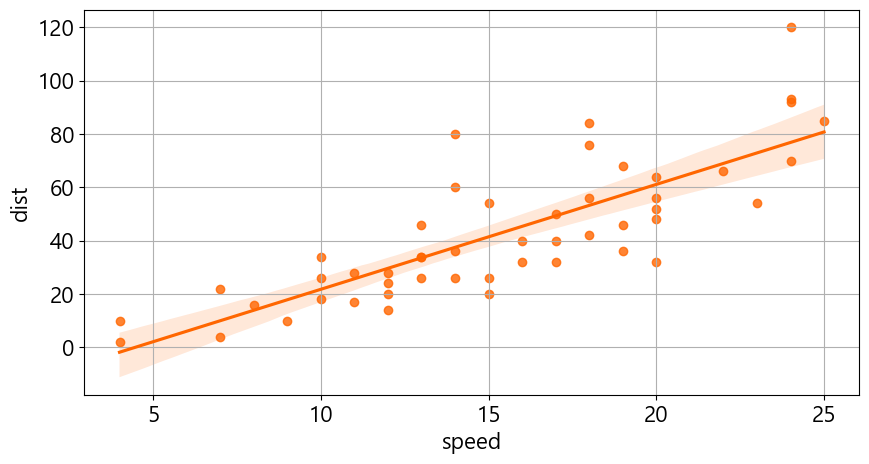

In [7]:
plt.rcParams['font.family'] = "Malgun Gothic"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
sb.regplot(data=origin, x= 'speed', y= 'dist', color= '#ff6600')
plt.grid()

plt.show()
plt.close()